# Documentation

# Sample

In [116]:
import marvin_titanic_engine
import os

In [117]:
print(os.getcwd())

/vagrant/projects/titanic-engine/notebooks


In [119]:
#from marvin_python_toolbox.common.data import MarvinData
import pandas as pd

train_df = pd.read_csv(
    '/vagrant/projects/titanic-engine/marvin_titanic_engine/data_files/train.csv'
)
test_df = pd.read_csv(
    '/vagrant/projects/titanic-engine/marvin_titanic_engine/data_files/train.csv'
)
marvin_initial_dataset = {
    'train': train_df,
    'test': test_df
}

## Training Preparator

In [120]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score, GridSearchCV

pred_cols = ['Age', 'Pclass', 'Sex']
dep_var = 'Survived'
train_no_na = marvin_initial_dataset['train'][
    pred_cols + [dep_var]
].dropna()
print("Length: {}".format(len(train_no_na)))

# Feature Engineering
data_X = train_no_na[pred_cols]
data_X.loc[:, 'Sex'] = data_X['Sex'].map({'male': 1, 'female': 0})
data_y = train_no_na[dep_var]

# Prepare for Stratified Shuffle Split
sss = StratifiedShuffleSplit(n_splits=5, test_size=.6, random_state=0)
sss.get_n_splits(data_X, data_y)
for train_index, test_index in sss.split(data_X, data_y):
    X_train, X_test = data_X.iloc[train_index], data_X.iloc[test_index]
    y_train, y_test = data_y.iloc[train_index], data_y.iloc[test_index]
marvin_dataset = {
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test,
    'sss': sss
}


Length: 714


## Trainer

In [121]:
from sklearn import svm, neighbors, tree
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LogisticRegression


# Set the parameter candidates
parameter_candidates = [
    {'C': [1, 10, 100], 'gamma': [0.01, 0.001], 'kernel': ['linear']},
    {'C': [1, 10, 100], 'gamma': [0.01, 0.001], 'kernel': ['rbf']},
]

# Create a classifier with the parameter candidates
svm_grid = GridSearchCV(estimator=svm.SVC(), param_grid=parameter_candidates, n_jobs=-1)

# Train the classifier on training data
svm_grid.fit(
    marvin_dataset['X_train'],
    marvin_dataset['y_train']
)

# use a full grid over all parameters
parameter_candidates = {
    "max_depth": [3, None],
    "random_state": [0],
    "min_samples_split": [2],  # , 3, 10],
    "min_samples_leaf": [1],  # , 3, 10],
    "n_estimators": [20],  # , 50],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

#clf = RandomForestClassifier(n_estimators=20)

# run grid search
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameter_candidates)
rf_grid.fit(
    marvin_dataset['X_train'],
    marvin_dataset['y_train']
)

marvin_model = {
    'svm': svm_grid,
    'rf': rf_grid
}

Model Type: rf
{'warm_start': False, 'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 20, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 0, 'min_impurity_split': 1e-07, 'max_features': 'auto', 'max_depth': None, 'class_weight': None}
Accuracy Score: 0.7895%
Classification Report:

             precision    recall  f1-score   support

          0       0.75      0.84      0.79       227
          1       0.79      0.68      0.73       202

avg / total       0.77      0.77      0.76       429

Confusion Matrix:

[[191  36]
 [ 64 138]]



Model Type: svm
{'kernel': 'rbf', 'C': 100, 'verbose': False, 'probability': False, 'degree': 3, 'shrinking': True, 'max_iter': -1, 'decision_function_shape': None, 'random_state': None, 'tol': 0.001, 'cache_size': 200, 'coef0': 0.0, 'gamma': 0.001, 'class_weight': None}
Accuracy Score: 0.786%
Classification Report:

            

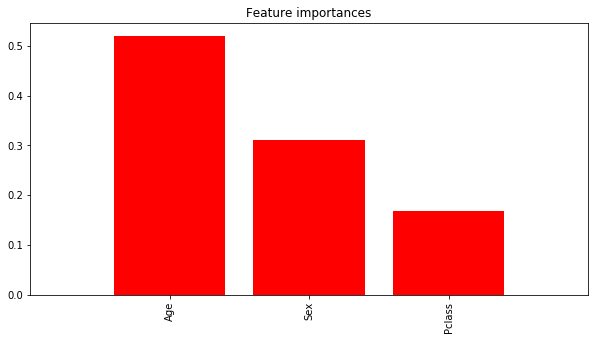

In [122]:
from sklearn import metrics
for model_type, fitted_model in marvin_model.iteritems():
    print("Model Type: {0}\n{1}".format(model_type, fitted_model.best_estimator_.get_params()))
    print("Accuracy Score: {}%".format(round(fitted_model.best_score_,4)))
    # Print the classification report of `y_test` and `predicted`
    print("Classification Report:\n")
    print(metrics.classification_report(fitted_model.predict(marvin_dataset['X_test']), marvin_dataset['y_test']))

    # Print the confusion matrix
    print("Confusion Matrix:\n")
    print(metrics.confusion_matrix(fitted_model.predict(marvin_dataset['X_test']), marvin_dataset['y_test']))
    print("\n\n")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#marvin_dataset['X_train']

importances = rf_grid.best_estimator_.feature_importances_

#std = np.std([rf_grid.best_estimator_.feature_importances_ for tree in rf_grid.estimators_],
#             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(marvin_dataset['X_train'].shape[1]):
    print("%d. feature %s (%f)" % (f + 1, pred_cols[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r",  align="center")
stats_order = [pred_cols[x] for x in indices]
plt.xticks(range(marvin_dataset['X_train'].shape[1]), stats_order, rotation='vertical')
plt.xlim([-1, marvin_dataset['X_train'].shape[1]])
plt.show()

## Predictor

In [123]:
# age, class, sex
input_message = [[50, 3, 0]]


final_result = {
    "prediction1": marvin_model['rf'].predict(input_message)[0],
    "prediction2": marvin_model['svm'].predict(input_message)[0]

}

final_result

{'prediction1': 0, 'prediction2': 1}